In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.ndimage.filters import gaussian_filter1d

#model
from sklearn.cluster import AgglomerativeClustering

#visualization
from scipy.cluster.hierarchy import dendrogram
# packages for cluster determination 
from sklearn.metrics import silhouette_samples, silhouette_score

In [ ]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


# 1. Clustering avg. Baseline consumption

In [ ]:
# load consumption data
consumption = pd.read_pickle('/content/drive/MyDrive/Stanford-TUBerlin/CodePaper/Consumption_Matrices/{}_accounts_actual_usage'.format('SB'))

# compute avg. consumption for baseline 
time_base = pd.date_range(start='1/1/2002',  end='11/1/2007', freq='2MS')
consumption_base = consumption[time_base]

consumption_avg = pd.DataFrame(index=consumption.index)
consumption_avg['avg_consumption'] = consumption_base.mean(axis=1)

In [ ]:
# cluster on avg consumption

linkage_list = ['ward', 'average', 'complete', 'single']

fig, ax = plt.subplots(2,2, figsize = (15,15))
ax = ax.ravel()

for i in range(4):
    
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage=linkage_list[i])
    model = model.fit(consumption_avg)
    plot_dendrogram(model, truncate_mode='level', p=5 , ax=ax[i])
    ax[i].set_title(f'linkage: {linkage_list[i]}', size=20)
    ax[i].set_ylabel('similarity')


In [ ]:
model = AgglomerativeClustering( n_clusters=4, linkage='ward')
model = model.fit(consumption_avg)

clusters = pd.DataFrame(index=consumption.index)
clusters['avg_consump'] = model.labels_
clusters['pattern']=  np.nan

In [ ]:
consumption_avg['cluster'] = clusters['avg_consump']

In [ ]:
consumption_avg.groupby('cluster').mean()

,avg_consumption
cluster,
0,544.536548
1,351.418046
2,949.898346
3,213.337016


# Cluster on Pattern

In [ ]:
# load pattern
pattern = pd.read_pickle('/content/drive/MyDrive/Stanford-TUBerlin/CodePaper/Residuals/pattern_SB')

In [ ]:
# silhouette score
cluster_groups = clusters.groupby('avg_consump')

for name, group in cluster_groups:
  pattern_group = pattern.loc[group.index].pattern.apply(pd.Series)
  range_n_clusters = range(2,10)

  fig, ax = plt.subplots(1, figsize=(10,7))

  silhouettes = []

  for n_clusters in range_n_clusters:
      # Initialize the clusterer with n_clusters value and a random generator
      # seed of 17 for reproducibility.
      clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage='complete')
      cluster_labels = clusterer.fit_predict(pattern_group)
      # The silhouette_score gives the average value for all the samples.
      # This gives a perspective into the density and separation of the formed
      # clusters
      silhouette_avg = silhouette_score(pattern_group, cluster_labels)
      silhouettes.append(silhouette_avg)
      
  ax.plot(range_n_clusters, silhouettes, 'o-')
  ax.set_ylabel('Average silhouette coefficient')
  ax.set_xlabel('K')
  ax.grid()
  fig.suptitle('Silhouette coefficient for group {}'.format(name))
  plt.show()

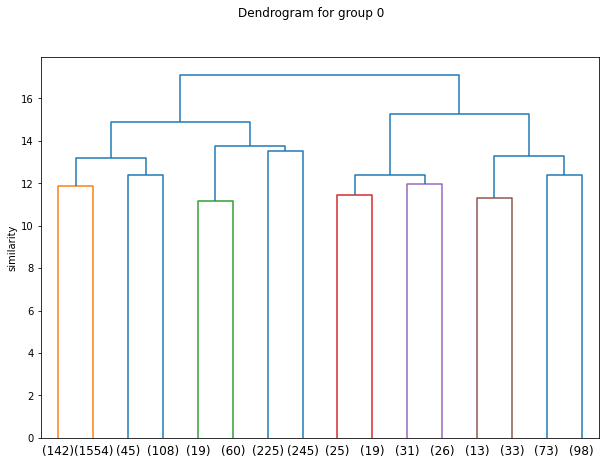

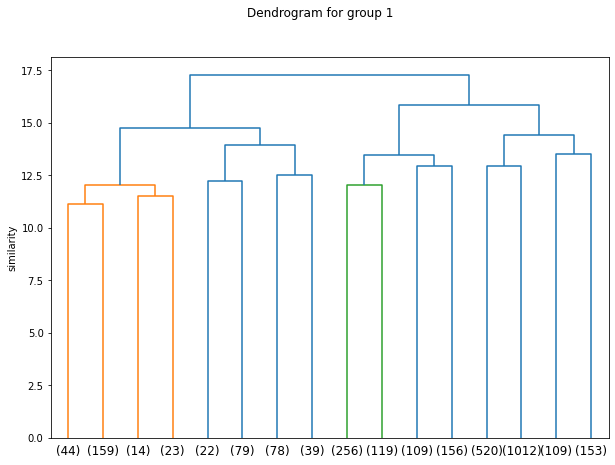

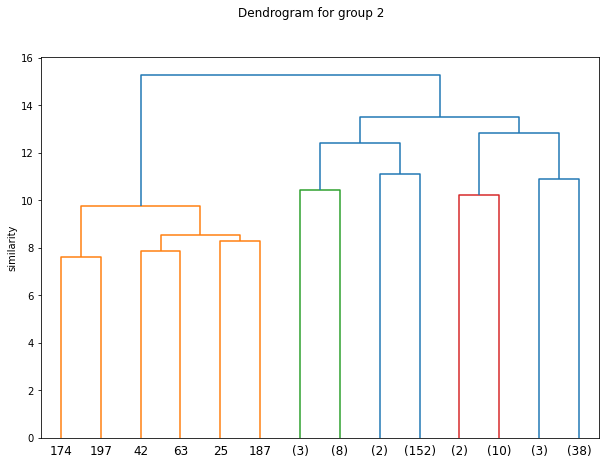

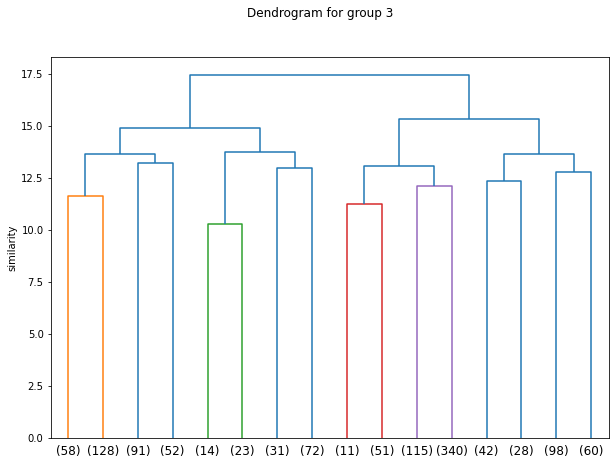

In [ ]:
# dendrogramm
cluster_groups = clusters.groupby('avg_consump')

for name, group in cluster_groups:
  pattern_group = pattern.loc[group.index].pattern.apply(pd.Series)

  fig, ax = plt.subplots(1, figsize=(10,7))
  model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='complete')
  model = model.fit(pattern_group)
  plot_dendrogram(model, truncate_mode='level', p=3 )
  ax.set_ylabel('similarity')
  fig.suptitle('Dendrogram for group {}'.format(name))
  plt.show()

In [ ]:
xtimeline = pd.date_range(start='1/1/2008',  end='7/1/2020', freq='2MS')

In [ ]:
len(time_base)

76

In [ ]:
cluster_groups = clusters.groupby('avg_consump')
n_clusters = [5, 5, 4, 4]
for i, (name, group) in enumerate(cluster_groups):
  pattern_group = pattern.loc[group.index].pattern.apply(pd.Series)
  model = AgglomerativeClustering( n_clusters=n_clusters[i], linkage='complete')
  labels = model.fit_predict(pattern_group)
  clusters.loc[group.index, 'pattern'] = labels.astype(int)




In [ ]:
clusters.to_pickle('/content/drive/MyDrive/Stanford-TUBerlin/CodePaper/Clustering/SB_clusters.pdf')

## Plots

In [ ]:
pattern_group = clusters.groupby(by=['avg_consump', 'pattern'])

### Barplot+ smooth

In [ ]:
import matplotlib.colors as colors
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

# adapt colormap
cmap = plt.get_cmap('Blues_r')
new_cmap = truncate_colormap(cmap, 0.1, 0.7)

In [ ]:
timeline = pd.date_range(start='1/1/2008',  end='7/1/2020', freq='2MS')
consump_group = ['high', 'medium', 'super', 'low']

for i, (name, group) in enumerate(pattern_group):
  toPlotpattern = pattern.loc[group.index].pattern.apply(pd.Series)
  toPlotpattern.columns = timeline
  barplot_df = pd.DataFrame(index = timeline, columns= [-1, 0, 1])
  for date in timeline:
    count = pd.value_counts(toPlotpattern[date])
    barplot_df.loc[date] =  count

  # sort groups
  categories = [1, 0, -1]
  barplot_df.columns = pd.CategoricalIndex(barplot_df.columns.values, 
                                 ordered=True, 
                                 categories=categories)
  # Sort the columns (axis=1) by the new categorical ordering
  barplot_df = barplot_df.sort_index(axis=1)
  
  #barplot
  ax1 = barplot_df.plot.bar(stacked=True, figsize=(10,6),color=['tab:red', 'tab:green', 'tab:blue'], width=1, rot=0, legend=False)
  
  #pattern from clusters smoothend
  toPlotMean = toPlotpattern.mean(axis=0)
  MeanSmoothed = pd.DataFrame(index = timeline, columns=['mean'], data =gaussian_filter1d(toPlotMean, sigma=2)) 
  ax2 = ax1.twinx()
  ax2.spines['right'].set_position(('axes', 1.0))
  ax2.set_ylim(-1,1)
  MeanSmoothed.plot(linestyle='-', linewidth = 2, color='k', use_index=False, ax=ax2)
  #ax2.tick_params(axis='y', labelcolor='tab:red')
  
  # merge legends
  lines, labels = ax1.get_legend_handles_labels()
  lines2, labels2 = ax2.get_legend_handles_labels()
  ax2.legend(lines + lines2, ['increase', 'no change', 'decrease'] + labels2)

  n=6
  ticks = ax1.xaxis.get_ticklocs()
  ax1.xaxis.set_ticks(ticks[::n])
  ax1.xaxis.set_ticklabels(barplot_df.index.year[::n])

  ax1.set_ylabel(' Count')
  ax2.set_ylabel(' Mean')

  plt.title('Consumption Group {} – Pattern Group {} – Count {}'.format(consump_group[name[0]], name[1], len(toPlotpattern)))
  plt.savefig('/content/drive/MyDrive/Stanford-TUBerlin/CodePaper/Clustering/SB/barplot/bar_{}_pattern{}.pdf'.format(consump_group[name[0]], name[1]))
  plt.close()